In [1]:
import mediapipe as mp
import cv2 as cv
import pandas as pd
import os
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Joint Determinations through an active feed
<img src="joints.png" style="height:300px" >

In [2]:
cap = cv.VideoCapture(0)

# Using the Pose model with specific confidence thresholds
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Recolouring the image
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False  # Prevents unnecessary caching

        # Make pose detection
        results = pose.process(image)

        # Recolor the image back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        try:
            # Get pose landmarks
            landmarks = results.pose_landmarks.landmark

            # Get normalized x and y coordinates for all landmarks
            height, width, _ = image.shape
            x_coords = [landmark.x * width for landmark in landmarks]
            y_coords = [landmark.y * height for landmark in landmarks]

            # Calculate bounding box
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))

            # Draw the bounding box
            cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Calculate and print height and width of the bounding box
            box_width = x_max - x_min
            box_height = y_max - y_min
            if (box_height<box_width):
                print("\n---\nheight less than width!\n---\n")
            print(f"Bounding Box: Width={box_width}, Height={box_height}")

            # Extract RIGHT_WRIST and LEFT_WRIST positions
            right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
            left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]

            # Print RIGHT_WRIST and LEFT_WRIST data if visible
            if right_wrist.visibility > 0.5 and left_wrist.visibility > 0.5:
                print(f"RIGHT_WRIST: x={right_wrist.x}, y={right_wrist.y}, z={right_wrist.z}, visibility={right_wrist.visibility}")
                print(f"LEFT_WRIST: x={left_wrist.x}, y={left_wrist.y}, z={left_wrist.z}, visibility={left_wrist.visibility}")

        except AttributeError:
            pass

        # Render pose landmarks on the image
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

        # Display the image
        cv.imshow('Mediapipe Feed', image)

        # Break the loop if 'q' is pressed
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv.destroyAllWindows()


Bounding Box: Width=434, Height=1285
Bounding Box: Width=446, Height=1262
Bounding Box: Width=459, Height=1252
Bounding Box: Width=439, Height=1256
Bounding Box: Width=422, Height=1259
Bounding Box: Width=419, Height=1267
Bounding Box: Width=430, Height=1283
Bounding Box: Width=454, Height=1292
Bounding Box: Width=466, Height=1291
Bounding Box: Width=474, Height=1290
Bounding Box: Width=488, Height=1289
Bounding Box: Width=485, Height=1289
Bounding Box: Width=472, Height=1291
Bounding Box: Width=466, Height=1286
Bounding Box: Width=461, Height=1283
Bounding Box: Width=464, Height=1285
Bounding Box: Width=470, Height=1291
Bounding Box: Width=472, Height=1293
Bounding Box: Width=471, Height=1292
Bounding Box: Width=470, Height=1292
Bounding Box: Width=474, Height=1291
Bounding Box: Width=479, Height=1291
Bounding Box: Width=481, Height=1291
Bounding Box: Width=479, Height=1295
Bounding Box: Width=461, Height=1293
Bounding Box: Width=455, Height=1293
Bounding Box: Width=456, Height=1292
B

# Reading through training data and marking coordinates into a csv file

>Whats happening here is simply a classification algorithm that mounts joints onto a person based on its visibility and then places a boundary box around the subject. Having done so the coordinates of these joints will be put into a CSV file alongside the image it was found in (the name of the image states if the person has fallen or not hence making it a trainable dataset

All that is happening here is that openCV is used to open an image detection frame and then media pipe is used to place joints over the images placed in that frame. Thereafter placing the joints, they will be put into a folder called "annotated images" and the image_name,coordinates (x,y), visibility, box_width and box_height will be put into a csv file to train the model

In [1]:
import os
import cv2 as cv
import mediapipe as mp
import pandas as pd

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Path to the folder containing images
input_folder = r"C:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\Fall_Detection\fall_dataset\images\train"
output_csv = "image_train_pose_coordinates.csv"

# Initialize a DataFrame to store joint data
columns = ["Image", "Joint", "X", "Y", "Visibility", "Box_Width", "Box_Height"]
pose_data = []

# Joints to exclude
excluded_joints = {
    "NOSE",
    "LEFT_EYE_INNER",
    "LEFT_EYE",
    "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER",
    "RIGHT_EYE",
    "RIGHT_EYE_OUTER",
    "LEFT_EAR",
    "RIGHT_EAR",
    "MOUTH_LEFT",
    "MOUTH_RIGHT",
}

# Using the Pose model
with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:  # Lowered thresholds
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Check if it's an image file
        if not (image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg")):
            print(f"Skipping non-image file: {image_name}")
            continue

        # Read the image
        image = cv.imread(image_path)
        if image is None:
            print(f"Skipping invalid image file: {image_name}")
            continue

        # Resize image for consistency and faster processing (optional)
        image = cv.resize(image, (640, 480))

        # Process the image
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Check if landmarks are detected
        if results.pose_landmarks and results.pose_landmarks.landmark:
            print(f"Pose landmarks detected for: {image_name}")
            # Get pose landmarks
            landmarks = results.pose_landmarks.landmark

            # Get image dimensions
            height, width, _ = image.shape

            # Initialize bounding box variables
            x_coords = []
            y_coords = []

            # Extract and save landmark data
            for idx, landmark in enumerate(landmarks):
                joint_name = mp_pose.PoseLandmark(idx).name
                if joint_name in excluded_joints:
                    continue  # Skip excluded joints

                x = landmark.x * width
                y = landmark.y * height
                visibility = landmark.visibility
                pose_data.append([image_name, joint_name, x, y, visibility, 0, 0])  # Placeholder for box width/height

                # Collect x and y coordinates for bounding box calculation
                x_coords.append(x)
                y_coords.append(y)

            # Calculate bounding box (min/max coordinates)
            if x_coords and y_coords:  # Ensure lists are not empty
                x_min = min(x_coords)
                x_max = max(x_coords)
                y_min = min(y_coords)
                y_max = max(y_coords)

                box_width = x_max - x_min
                box_height = y_max - y_min

                # Update the CSV data with bounding box dimensions
                for i in range(len(pose_data)):
                    if pose_data[i][0] == image_name:
                        pose_data[i][5] = box_width
                        pose_data[i][6] = box_height

                # Draw landmarks on the image
                annotated_image = image.copy()
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                )

                # Draw the bounding box around the pose
                cv.rectangle(annotated_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

                # Save the annotated image
                output_folder = "annotated_images"
                os.makedirs(output_folder, exist_ok=True)
                output_image_path = os.path.join(output_folder, f"annotated_{image_name}")
                cv.imwrite(output_image_path, annotated_image)
        else:
            print(f"No pose landmarks detected in: {image_name}")

# Save data to CSV
pose_df = pd.DataFrame(pose_data, columns=columns)
pose_df.to_csv(output_csv, index=False)
print(f"Pose coordinates saved to {output_csv}")


Pose landmarks detected for: fall001.jpg
No pose landmarks detected in: fall002.jpg
Pose landmarks detected for: fall003.jpg
Pose landmarks detected for: fall004.jpg
Pose landmarks detected for: fall005.jpg
Pose landmarks detected for: fall006.jpg
Pose landmarks detected for: fall007.jpg
No pose landmarks detected in: fall008.jpg
Pose landmarks detected for: fall009.jpg
Pose landmarks detected for: fall010.jpg
Pose landmarks detected for: fall011.jpg
Pose landmarks detected for: fall012.jpg
Pose landmarks detected for: fall013.jpg
Pose landmarks detected for: fall014.jpg
Pose landmarks detected for: fall015.jpg
Pose landmarks detected for: fall016.jpg
No pose landmarks detected in: fall017.jpg
Pose landmarks detected for: fall018.jpg
Pose landmarks detected for: fall019.jpg
Pose landmarks detected for: fall020.jpg
Pose landmarks detected for: fall021.jpg
Pose landmarks detected for: fall022.jpg
Pose landmarks detected for: fall023.jpg
Pose landmarks detected for: fall024.jpg
Pose landm

# Plotting out the information gain

Here I plotted out the information gain for each joint to see which joints were the most analysed when making a prediction to see if an individual was in the process of falling. This could then lead to pre-requisites to setting up the camera such that these joints are made to be the most visible

In the first code snippet below, the dataset is being reshaped such that each unique joint is made into a feature/column and then put up against the outcome label marking if the combinations of joints are a fall or not

In [2]:
import pandas as pd

# Load the pose data CSV
input_csv = "image_train_pose_coordinates.csv"
output_csv = "reshaped_pose_data.csv"

# Read the CSV into a DataFrame
pose_df = pd.read_csv(input_csv)

# Add a new column for the outcome label
pose_df["Label"] = pose_df["Image"].apply(
    lambda x: "Fall" if "fall" in x.lower() and "not" not in x.lower() else "Not Fall"
)

# Create a unique identifier for each image to reshape the data
pose_df["Image_Label"] = pose_df["Image"] + "_" + pose_df["Label"]

# Reshape the data: Pivot each joint's X, Y, and Visibility into separate columns
reshaped_df = pose_df.pivot(
    index="Image_Label",
    columns="Joint",
    values=["X", "Y", "Visibility"]
)

# Flatten the multi-index columns
reshaped_df.columns = [f"{stat}_{joint}" for stat, joint in reshaped_df.columns]

# Reset the index to include Image_Label as a column
reshaped_df = reshaped_df.reset_index()

# Split Image_Label back into Image and Label columns
reshaped_df[["Image", "Label"]] = reshaped_df["Image_Label"].str.split("_", n=1, expand=True)

# Drop the temporary Image_Label column
reshaped_df = reshaped_df.drop(columns=["Image_Label"])

# Save the reshaped DataFrame to a new CSV
reshaped_df.to_csv(output_csv, index=False)
print(f"Reshaped data saved to {output_csv}")

Reshaped data saved to reshaped_pose_data.csv


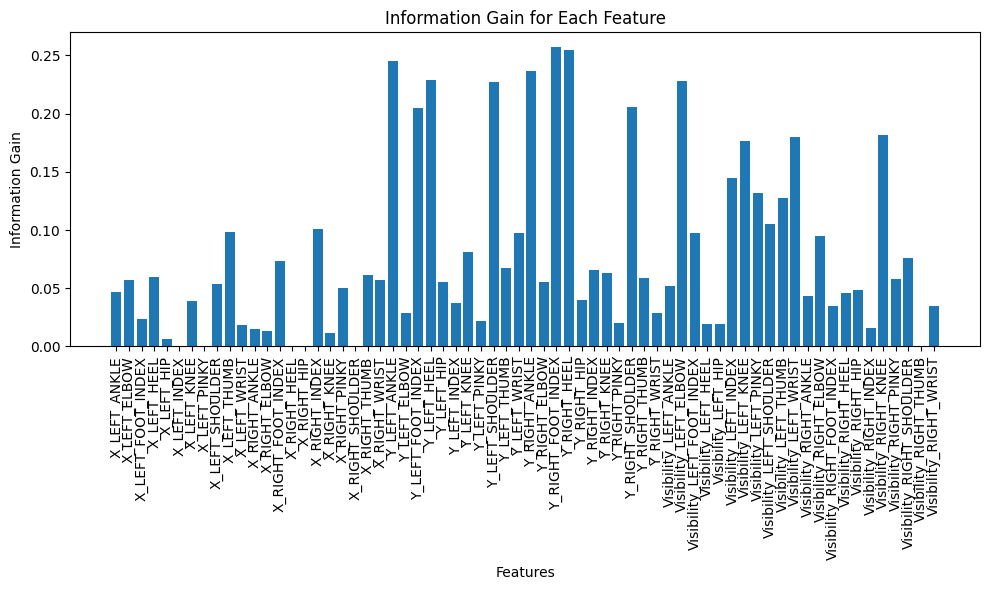

In [3]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

# Load the reshaped data
data = pd.read_csv("reshaped_pose_data.csv")

# Separate features and target
X = data.drop(columns=["Image", "Label"])  # Drop non-feature columns
y = data["Label"]

# Encode the labels (if they are strings)
y_encoded = y.map({"Fall": 1, "Not Fall": 0}).astype(int)

# Compute mutual information (information gain)
info_gain = mutual_info_classif(X, y_encoded, discrete_features=False)

# Plot information gain
plt.figure(figsize=(10, 6))
plt.bar(X.columns, info_gain)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Information Gain")
plt.title("Information Gain for Each Feature")
plt.tight_layout()
plt.show()

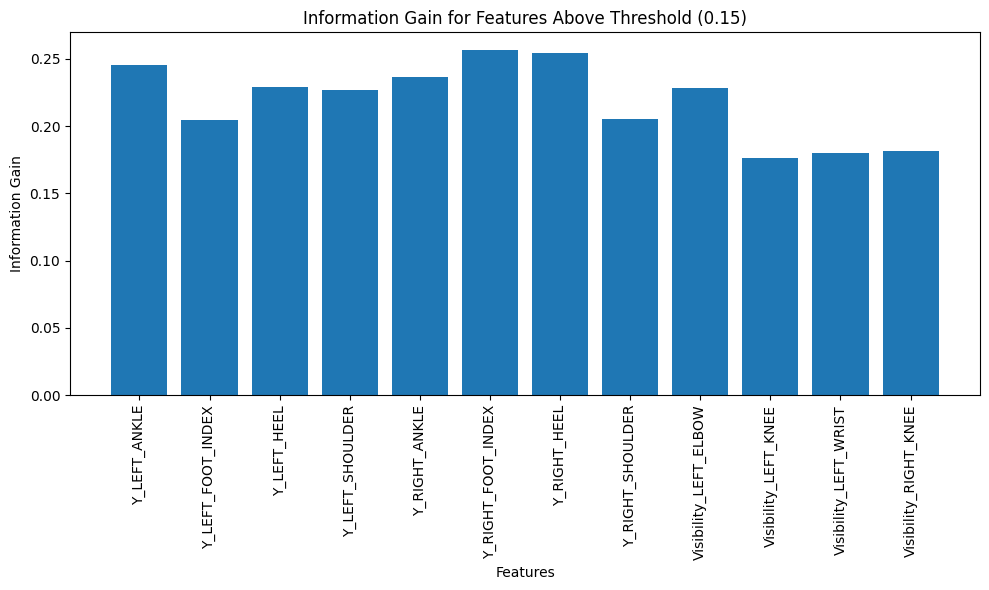

In [4]:
# Filter features with information gain > 0.15
selected_features = X.columns[info_gain > 0.15]
selected_info_gain = info_gain[info_gain > 0.15]

# Plot filtered information gain
plt.figure(figsize=(10, 6))
plt.bar(selected_features, selected_info_gain)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Information Gain")
plt.title("Information Gain for Features Above Threshold (0.15)")
plt.tight_layout()
plt.show()

# Pre Processing the dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV file
csv_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(csv_path)

# Extract the target label (fall or no_fall) from the image name
df["Label"] = df["Image"].apply(lambda x: 1 if x.lower().startswith("fall") else 0)

# Features and target
features = ["X", "Y", "Visibility", "Box_Width", "Box_Height"]
X = df[features]
y = df["Label"]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)# Test size set to 20%

# Count the number of falls and non-falls
fall_counts = df["Label"].value_counts()

# Display the counts
print("Number of non-falls:", fall_counts[0])
print("Number of falls:", fall_counts[1])

Number of non-falls: 3124
Number of falls: 3784


# Assessing which model is the most optimal

> A cross validation is to be carried out amongst the mentioned models such that the model that performs the best will be used towards the end for real time predictions

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Define the models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Iterate over the models and perform cross-validation
for model_name, model in models.items():
    # Perform 5-fold cross-validation and print the mean accuracy score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Cross-validation mean accuracy: {cv_scores.mean():.4f}")

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set and evaluate
    y_pred = model.predict(X_test)
    print(f"Accuracy of {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Logistic Regression - Cross-validation mean accuracy: 0.7570
Accuracy of Logistic Regression: 0.7641
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       596
           1       0.79      0.80      0.79       786

    accuracy                           0.76      1382
   macro avg       0.76      0.76      0.76      1382
weighted avg       0.76      0.76      0.76      1382

--------------------------------------------------
Support Vector Classifier - Cross-validation mean accuracy: 0.8194
Accuracy of Support Vector Classifier: 0.8119
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       596
           1       0.82      0.85      0.84       786

    accuracy                           0.81      1382
   macro avg       0.81      0.81      0.81      1382
weighted avg       0.81      0.81      0.81      1382

--------------------------------------------------
Random Forest - Cross-validati

# Training the model

> A random forest and logistic regression model are assessed here to see which of the two can perform better

In [5]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Specifying the Random Forest model and its hyperparameters
model_param = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=42),  # Setting the random state for reproducibility
        'param': {
            'n_estimators': [25, 50, 75, 100],  # Number of trees in the forest
            'criterion': ['gini', 'entropy', 'log_loss'],  # Splitting criterion
            'max_depth': [2, 3, 5, None],  # Max depth of trees
            'max_features': ['sqrt', 'log2', None],  # Features to consider for splits
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at a leaf node
        }
    }
}

# Extract the model and the parameters
model = model_param['RandomForestClassifier']['model']
param_grid = model_param['RandomForestClassifier']['param']

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data (using training data X_train and y_train)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the model with the best hyperparameters
best_model = grid_search.best_estimator_

# Save the best model to a file using joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("Best model saved to 'best_random_forest_model.pkl'")

# Evaluate the model with the best parameters
y_pred = best_model.predict(X_test)

# Print accuracy and classification report for the best model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
Best model saved to 'best_random_forest_model.pkl'
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       786

    accuracy                           1.00      1382
   macro avg       1.00      1.00      1.00      1382
weighted avg       1.00      1.00      1.00      1382


# Using an active feed

In [3]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the saved RandomForest model to get the best parameters
best_rf_model = joblib.load('best_random_forest_model.pkl')
print("Random Forest Model loaded from 'best_random_forest_model.pkl'")

# Extract the parameters used for the Random Forest model
best_params = best_rf_model.get_params()
print("Best Parameters extracted from the model:", best_params)

# Initialize the new Random Forest classifier with the extracted parameters
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Load training data (X_train, y_train) - You need to load or create this dataset
# For the purpose of illustration, make sure you have the training data available
# X_train, y_train = ...

# Train the new Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Open the video capture
cap = cv.VideoCapture(0)

# Start pose detection
with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        # Preprocess frame
        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Detect pose landmarks
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark

            # Extract key points (you can add more body parts for better results)
            hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
            ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]
            shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            elbow = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
            wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]

            # Feature engineering: Calculating distances and angles (example)
            # Distance between hip and ankle (vertical drop in body position)
            hip_ankle_dist = np.linalg.norm([hip.x - ankle.x, hip.y - ankle.y])
            shoulder_wrist_dist = np.linalg.norm([shoulder.x - wrist.x, shoulder.y - wrist.y])

            # Bounding box calculation
            x_coords = [lm.x * width for lm in landmarks]
            y_coords = [lm.y * height for lm in landmarks]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Prepare input for the model - Ensure only 5 features
            features_input = np.array([
                np.mean(x_coords),  # Average x position
                np.mean(y_coords),  # Average y position
                hip_ankle_dist,      # Vertical drop
                shoulder_wrist_dist, # Distance between shoulder and wrist
                box_width            # Bounding box width (we'll use only 5 features)
            ])

            # Make prediction using the new Random Forest model
            rf_prediction = rf_model.predict([features_input])[0]
            rf_label = "Falling" if rf_prediction == 1 else "Not Falling"

            # Annotate the frame with predictions
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, rf_label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv.imshow("Fall Detection", frame)

        # Break loop on 'q' key press
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()


Random Forest Model loaded from 'best_random_forest_model.pkl'
Best Parameters extracted from the model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 25, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       596
           1       1.00      1.00      1.00       786

    accuracy                           1.00      1382
   macro avg       1.00      1.00      1.00      1382
weighted avg       1.00      1.00      1.00      1382


# Utilizing a logistic Regression Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

# Evaluate the model
y_pred = LR_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.76410998552822
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       596
           1       0.79      0.80      0.79       786

    accuracy                           0.76      1382
   macro avg       0.76      0.76      0.76      1382
weighted avg       0.76      0.76      0.76      1382


In [6]:
import cv2 as cv
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

cap = cv.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        # Preprocess frame
        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Detect pose landmarks
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark

            # Extract features for prediction
            x_coords = [lm.x * width for lm in landmarks]
            y_coords = [lm.y * height for lm in landmarks]
            visibilities = [lm.visibility for lm in landmarks]

            # Calculate bounding box
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Prepare input for the model
            features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
            features_input_scaled = scaler.transform([features_input])

            # Make prediction
            prediction = LR_model.predict(features_input_scaled)[0]
            label = "Falling" if prediction == 1 else "Not Falling"

            # Annotate the frame
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv.imshow("Fall Detection", frame)

        # Break loop on 'q' key press
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()

C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St

# Utlizing a KNN model

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 21),  # Test n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weighting
    'p': [1, 2]  # Test Manhattan (1) and Euclidean (2) distance metrics
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='accuracy',  # Evaluate models using accuracy
    cv=5,  # Use 5-fold cross-validation
    verbose=2,  # Print progress during tuning
    n_jobs=-1  # Use all available processors
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the model with the best parameters on the entire training set
best_knn_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_knn_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9397411077381295
Test Accuracy: 0.9399421128798843
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       596
           1       0.96      0.94      0.95       786

    accuracy                           0.94      1382
   macro avg       0.94      0.94      0.94      1382
weighted avg       0.94      0.94      0.94      1382


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model
y_pred = knn_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8835021707670043
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       596
           1       0.91      0.88      0.90       786

    accuracy                           0.88      1382
   macro avg       0.88      0.88      0.88      1382
weighted avg       0.88      0.88      0.88      1382


In [9]:
import cv2 as cv
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

cap = cv.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        # Preprocess frame
        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Detect pose landmarks
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark

            # Extract features for prediction
            x_coords = [lm.x * width for lm in landmarks]
            y_coords = [lm.y * height for lm in landmarks]
            visibilities = [lm.visibility for lm in landmarks]

            # Calculate bounding box
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Prepare input for the model
            features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
            features_input_scaled = scaler.transform([features_input])

            # Make prediction
            prediction = knn_model.predict(features_input_scaled)[0]
            label = "Falling" if prediction == 1 else "Not Falling"

            # Annotate the frame
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv.imshow("Fall Detection", frame)

        # Break loop on 'q' key press
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()

C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St